Y3880931

This version of the snake game allows you to implement and run your evolutionary algorithm

In [1]:
import random
import time
import turtle
import deap
from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import algorithms
import numpy as np


In [2]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [3]:
HEADLESS = False

In [4]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("red")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color('black')
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [5]:
class snake:
    
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def getAheadLocation(self):
        self.ahead = [ self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)] 
    
    def sense_wall_ahead(self):
        self.getAheadLocation()
        return( self.ahead[0] == 0 or self.ahead[0] == (YSIZE-1) or self.ahead[1] == 0 or self.ahead[1] == (XSIZE-1) )
    
    def sense_tail_ahead(self):
        self.getAheadLocation()
        return self.ahead in self.snake
    
    def movingDirection(self):
        if self.snake_direction == "up":
            return 1
        elif self.snake_direction == "down":
            return 2
        elif self.snake_direction == "left":
            return 3
        elif self.snake_direction == "right":
            return 4
        
    def isFood(self, pos):
        if self.food == pos:
            return True
        else:
            return False
        
    def isBody(self, pos):
        if pos in self.snake:
            return True
        else:
            return False
    
    def isWall(self, pos):
        if pos[0] <= 0 or pos[0] >= self.YSIZE-1 or pos[1] <= 0 or pos[1] >= (self.XSIZE-1):
            return True
        else:
            return False
        
    #Movement functions
    def moveRight(self):
        self.snake_direction = "right"
    def moveLeft(self):
        self.snake_direction = "left"
    def moveUp(self):
        self.snake_direction = "up"
    def moveDown(self):
        self.snake_direction = "down"
        
    
    def look(self,direction, display):       # Returning if there is food / a body segment and where the wall is for a given direction
        info = np.zeros(3)
        head = self.snake[0]
        pos = [head[0] + direction[0], head[1] + direction[1]]
        distance = 1                               # The commented code was to help visualise what the snake is seeing to make sure it was implemented correctly
        '''if (display != None):                   
            locationF = turtle.Turtle()
            locationB = turtle.Turtle()
            locationW = turtle.Turtle()
            locationE = turtle.Turtle()'''
        while not (self.isWall(pos)):
            if self.isFood(pos):
                info[0] = 1               # Boolean return if there is food
                '''if display != None:
                        locationF.speed(0)
                        locationF.shape("square")
                        locationF.color("green")
                        locationF.shapesize(0.5, 0.5)
                        locationF.penup()
                        locationF.goto(((pos[1]-9)*20)+20, (((9-pos[0])*20)-10)-20)'''
            elif self.isBody(pos):
                info[1] = 1               # Boolean return if there is a body segment
                '''if display != None:
                        locationB.speed(0)
                        locationB.shape("square")
                        locationB.color("red")
                        locationB.shapesize(0.4, 0.4)
                        locationB.penup()
                        locationB.setposition(((pos[1]-9)*20)+20, (((9-pos[0])*20)-10)-20)'''
            '''else:
                if display != None:
                        locationE.speed(0)
                        locationE.shape("circle")
                        locationE.color("snow")
                        locationE.shapesize(0.2, 0.2)
                        locationE.penup()
                        locationE.setposition(((pos[1]-9)*20)+20, (((9-pos[0])*20)-10)-20)'''
            distance += 1
            pos = [pos[0] + direction[0], pos[1] + direction[1]]

        '''if display != None:
                locationW.speed(0)
                locationW.shape("square")
                locationW.color("blue")
                locationW.shapesize(0.4, 0.4)
                locationW.penup()
                locationW.setposition(((pos[1]-9)*20)+20, (((9-pos[0])*20)-10)-20)'''
        info[2] = 1/distance            # Returning the inverse distance of the wall
        return info
    
    
    def moveSnakeAI(self, AI, display):
        inputVector = np.zeros(24)        # Neural network input
        lookingDirections = [[-1,0], [-1,-1], [0,-1], [1,-1], [1,0], [1,1], [0,1], [-1,1]]     # All 8 normalised directions the snake will be able to "look"
        
        for i in range(8):    # Looping over all the directions and gathering information about what's in that direction
            info = self.look(lookingDirections[i], display)
            inputVector[i*3] = info[0]
            inputVector[(i*3)+1] = info[1]
            inputVector[(i*3)+2] = info[2]
        
        output = AI.feedForward(list(inputVector))
        decision = np.argmax(output, axis=0)
        if decision == 0:
            self.moveRight()
        elif decision == 1:
            self.moveLeft()
        elif decision == 2:
            self.moveUp()
        elif decision == 3:
            self.moveDown()
            

In [6]:
display = DisplayGame(XSIZE,YSIZE)
snake_game = snake(XSIZE,YSIZE)

In [7]:
def run_game(AI,snake_game, headless=False, display = None):
    moves = 0
    score = 0
    energy = 1             # Initial energy meter
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    flag = True
    while not game_over:
        
        # ****YOUR AI BELOW HERE******************
        moves += 1
        energy -= 0.01                           # energy decreasing every move
        snake_game.moveSnakeAI(AI, display)
        
        
        # ****YOUR AI ABOVE HERE******************
            
        snake_game.update_snake_position()

        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            energy = 2.5           # Setting energy higher to allow the snakes to make more moves later on in the game
                                   # and resets every time the snake eats
            if not headless: display.add_snake_segment()

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
        
        # Game over if the snakes runs out of energy
        if energy <= 0:
            game_over = True
        
        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.15) # Change this to modify the speed the game runs at when displayed.

    if not headless: turtle.done()
    return [score, moves]


In [8]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1
        
        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer

        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [9]:
numInputNodes = 24
numHiddenNodes1 = 24
numHiddenNodes2 = 20
numOutputNodes = 4

# Defining the individual size based on the size of the neural network
IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

In [10]:
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)   # Defining the neural network architecture

In [11]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

def evaluate(indiv, myNet):
    score = 0
    fitness = 0
    myNet.setWeightsLinear(indiv)
    for i in range(4):            # Running the same individual 4 times to get an average fitness
        results = run_game(myNet,snake_game, headless=True)
        score += results[0]
        fitness += (100*results[0]) + (results[1])
    #print(score/4)
    return fitness/4,

In [12]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=100)   # Tournament selection with 10% of the population participating

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

I chose to represent the individuals as weights of a neural network as evolving a neural network to play games is a thoroughly researched area and proven to be the best way to solve this type of problem due to its power of being able to encode complex movements and strategies in a relatively small network. This is ideal as because it's a small network I can run the training on more generations than I would've been able to with a bigger network and it running in a reasonable amount of time. I chose to use a 2 hidden layered network as running the algorithm with 3 layers yielded worse results, as proven in the graphs at the end of the notebook, which I suspect is because it needed to be trained for more generations to fine tune the higher number of network weights it has. I chose to give the snake 8 directional sensing up until the walls so that wherever the snake is moving it is very likely to sense where the food is on the map as well as being able to sense danger in the 8 adjacent blocks around the head with also vision further ahead. My other option was giving the snake information of every space on the map but I chose not to use this method as that would've made the number of inputs for the neural network very large (256) which would've slowed down training considerably.

I set my fitness function as the number of food eaten by the snake plus how long the snake survives for calculated by the number of moves it makes. I avoided the snakes just learning to survive and not go for the food by setting an energy level for each snake and decrementing it slightly every move and resetting it when the snake eats a food. I also weighted the number of food eaten by the snake considerably more to reward the snakes for getting a higher score more than surviving longer so that the training takes less time (because they don't aim to just survive as long as possible) and it prioritises getting food rather than just how long it stays alive for.

In [13]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [14]:
logbook = tools.Logbook()

pop = toolbox.population(n=1000)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [15]:
NGEN = 125

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
          
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
   
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

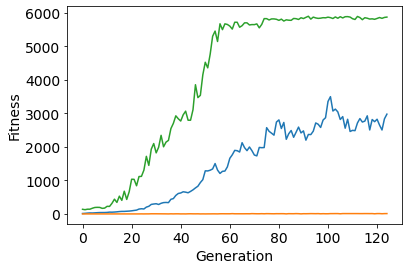

In [17]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

In [21]:
bestInd = tools.selBest(pop, 1)[0]
myNet.setWeightsLinear(bestInd)

In [25]:
fitness = 0
for i in range (20):       # Getting an average score for the best individual over 20 runs 
    temp = run_game( myNet,snake_game, headless=True, display=display)
    fitness += temp[0]
print(fitness/20)

42.35


In [26]:
fitness = run_game( myNet,snake_game, headless=False, display=display)

KeyboardInterrupt: 

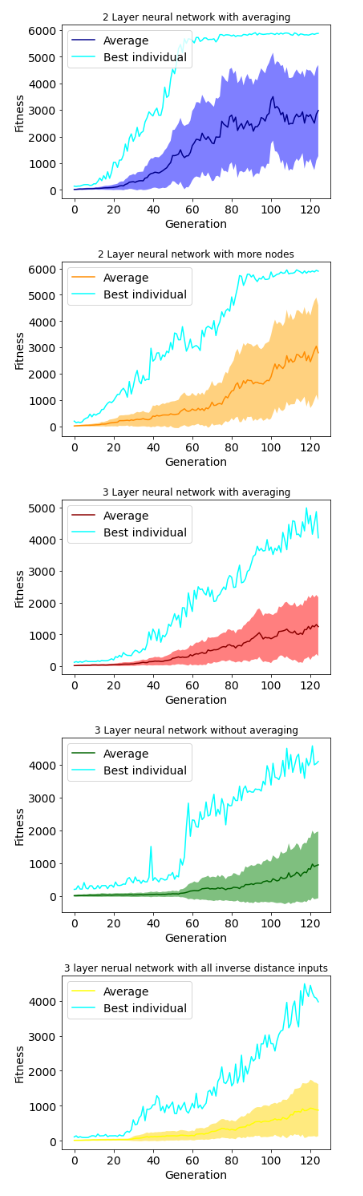

As you can see from the plots above, I found the best results to be when I had a 2 layered network with 24 nodes in the first hidden layer and 20 in the second. This is shown by the fact that the best individuals in each generation reached the best solution very early on around generation 50. This is then followed by the average of the population climbing at the same pace as some of the best individuals did in other runs. Also, as shown by the standard deviation ribbon around each average line, the first run had the highest std which means that the population were getting a wide range of fitnesses which means a large portion of the population by the end of the evolution were capable of reaching high scores that rivel those of the best invidividuals of other runs. Another thing to point out, these plots show how effective averaging the fitness scores of individuals is as without averaging the population required a lot more generations to start learning as compared to their averaged counterpart. Finally, being decided that averaging and 2 layered neural networks where the best solution, I tried to increase the number of nodes in the 2 hidden layers but that proved to only slow down the learning of the population.

# Best individual:
<img src="gif.gif" width="200" align="center">
(Best snake gif)

To summerise my findings, I found that giving the snakes boolean and normalised inputs as "vision" allowed the snakes to learn how to avoid the walls and their body well. I attempted to input the distance to the food or a body segment if detected but the model couldn't seem to learn based off of that input so giving a true or false (1 or 0) input worked much better. Averaging a couple of runs of each individual to evaluate their fitness made it so that it's very unlikely a snake will get a high fitness score due to pure luck which made the evaluation of each individual more accurate and robust. Testing out different architectures for the neural network I found that having 3 layers performed worse than only having 2 layers. As I mentioned previously, I believe if I allowed the 3 layered network to evovlve for more generations then it might've surpassed the fitness score ceiling that the 2 layered network hit. If I were to suggest modifications to improve this algorithm I would say to add more sensing directions, I'm only using 8, and ideally provide a snapshot of the entire map, or a portion of it such as 4/8 blocks in all directions around the head of the snake, and give every coordinate on the map as an input. Alongside that I would suggest enlarging the network so that given all the information it's recieving it can evolve a more complex strategy with it. I chose not to use this method as I don't have a powerful enough processor to run the algorithm in a reasonable amount of time. Using NEAT to be able to evolve the neural network architecture would also most likely dramatically increase the scores achievable as well as decreasing the training time to reach that score. 